In [1]:
# import function we need
import keras
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv2D, Conv2DTranspose
from keras.models import Model
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers

In [2]:
#process data
data = pickle.load(open('./data_after_process/EECE7397/EECE7397_cache', "rb"))

In [4]:
use_data = []
for i in range(0,len(data)):
    use_data.append(np.array(data[i][:]).T)
use_data = np.array(use_data)

In [5]:
#use_data = np.array(data[0][:])
#for i in range(1,len(data)):
#    np.concatenate([use_data,np.array(data[i][:])], axis = 2)

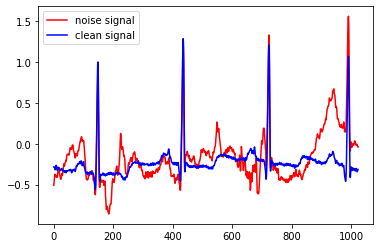

In [6]:
# use_data(1,:,0) is the first people noise data, and use_data(1,:,1) is the first people clean data
num = 0 # if we choose the first patient
plt.figure()
plt.plot(range(0,np.size(use_data,2)),use_data[num][0][:],'r-')
plt.plot(range(0,np.size(use_data,2)),use_data[num][1][:],'b-')
plt.legend(['noise signal','clean signal'])

In [33]:
#start to build auto-encoder here
train_size = int(np.floor(0.6*np.size(use_data,0))) # 0.6  determine trainn validation and test size here
validation_size = int(np.floor(0.8*np.size(use_data,0)))  #0.2
test_size = np.size(use_data,0)  #0.2

encoding_dim = 128 #32 #the input size is 1024, and the compression size is 128

input_signal = Input(shape =(np.size(use_data,2),1,1)) # np.size(use_data,2) = 1024
###################################################### core
#encode paer
#encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_signal)

convolution_1d_layer1 = keras.layers.Conv2D(40, (16,1), strides=(2,1), padding='same', activation="relu")(input_signal)

convolution_1d_layer2 = keras.layers.Conv2D(20, (16,1), strides=(2,1), padding='same', activation="relu")(convolution_1d_layer1)

convolution_1d_layer3 = keras.layers.Conv2D(20, (16,1), strides=(2,1), padding='same', activation="relu")(convolution_1d_layer2)

convolution_1d_layer4 = keras.layers.Conv2D(20, (16,1), strides=(2,1), padding='same', activation="relu")(convolution_1d_layer3)

convolution_1d_layer5 = keras.layers.Conv2D(40, (16,1), strides=(2,1), padding='same', activation="relu")(convolution_1d_layer4)

encoded = keras.layers.Conv2D(1, (16,1), strides=(1,1), padding='same',  activation="relu")(convolution_1d_layer5)


#decode part
#decoded = Dense(np.size(use_data,2), activation='sigmoid')(encoded)
deconvolution_1d_layer1 = keras.layers.Conv2DTranspose(1, (16,1), strides=(1,1), padding='same', activation="relu")(encoded)

deconvolution_1d_layer2 = keras.layers.Conv2DTranspose(40, (16,1), strides=(2,1), padding='same', activation="relu")(deconvolution_1d_layer1)

deconvolution_1d_layer3 = keras.layers.Conv2DTranspose(20, (16,1), strides=(2,1), padding='same', activation="relu")(deconvolution_1d_layer2)

deconvolution_1d_layer4 = keras.layers.Conv2DTranspose(20, (16,1), strides=(2,1), padding='same', activation="relu")(deconvolution_1d_layer3)

deconvolution_1d_layer5 = keras.layers.Conv2DTranspose(20, (16,1), strides=(2,1), padding='same', activation="relu")(deconvolution_1d_layer4)

deconvolution_1d_layer6 = keras.layers.Conv2DTranspose(40, (16,1), strides=(2,1), padding='same', activation="relu")(deconvolution_1d_layer5)

#decode= keras.layers.Conv2DTranspose(40, (16,1), strides=(2,1), padding='valid', activation="relu")(deconvolution_1d_layer5)


decoded = keras.layers.Conv2DTranspose(1, (16,1), strides=(1,1), padding='same', activation="relu")(deconvolution_1d_layer6)
####################################################### core
#input_data = Input(shape=(np.size(use_data,2),))

#autoencoder = Model(input_signal, decoded)
#encoder = Model(input_signal, encoded)  # encoder model

#encoded_input = Input(shape=(int(np.size(deconvolution_1d_layer6,3)),))#(encoding_dim,1,1))
#decoder_layer = autoencoder.layers[-1]
#decoder = Model(encoded_input, decoder_layer(encoded_input))  #decoder model

autoencoder = Model(input_signal, decoded)

# this model maps an input to its reconstruction
#autoencoder = Model(input_signal, decoded)

#train model
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #'mse')#

x_noise_data = use_data[:,0,:]
x_noise_data_use = x_noise_data 
for i in range(np.size(x_noise_data,0)): #normalize dat
    x_noise_data_use[i,:] = (x_noise_data[i,:] - np.min(x_noise_data[i,:]))/(np.max(x_noise_data[i,:]) - np.min(x_noise_data[i,:]))
x_noise_data_use = np.expand_dims(x_noise_data_use, axis=2)
x_noise_data_use = np.expand_dims(x_noise_data_use, axis=3)

x_correct_data =  use_data[:,1,:]
x_correct_data_use =x_correct_data
for i in range(np.size(x_noise_data,0)): #normalize data
    x_correct_data_use[i,:] = (x_correct_data[i,:] - np.min(x_correct_data[i,:]))/(np.max(x_correct_data[i,:]) - np.min(x_correct_data[i,:]))
x_correct_data_use = np.expand_dims(x_correct_data_use, axis=2)
x_correct_data_use = np.expand_dims(x_correct_data_use, axis=3)

autoencoder.fit(x_noise_data_use[0:train_size,:], x_correct_data_use[0:train_size,:],
                epochs=20, #50
                batch_size=128,#256,
                shuffle=True,
                validation_data=(x_noise_data_use[train_size:validation_size,:], x_correct_data_use[train_size:validation_size,:]))

Train on 5520 samples, validate on 1840 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
5520/5520 [==============================] - 25s 5ms/sample - loss: 105.7276 - val_loss: 80.0357
Epoch 2/20
5520/5520 [==============================] - 26s 5ms/sample - loss: 79.8469 - val_loss: 80.7928
Epoch 3/20
5520/5520 [==============================] - 27s 5ms/sample - loss: 80.4293 - val_loss: 83.4261
Epoch 4/20
5520/5520 [==============================] - 28s 5ms/sample - loss: 80.7662 - val_loss: 80.3462
Epoch 5/20
5520/5520 [==============================] - 26s 5ms/sample - loss: 80.5684 - val_loss: 79.7841
Epoch 6/20
5520/5520 [==============================] - 26s 5ms/sample - loss: 79.7967 - val_loss: 79.6905
Epoch 7/20
5520/5520 [==============================] - 26s 5ms/sample - loss: 79.9295 - val_loss: 79.5564
Epoch 8/20
5520/5520 [==============================] - 26s 5ms/sample - loss: 79.7522 - val_loss: 79.5118
Epoch 9/20
5520/5520 [=========================

In [35]:
# test the resul
#encode_result = encoder.predict(x_noise_data[validation_size:test_size,:])
decode_result = autoencoder.predict(x_noise_data_use[validation_size:test_size,:])#decoder.predict(encode_result)

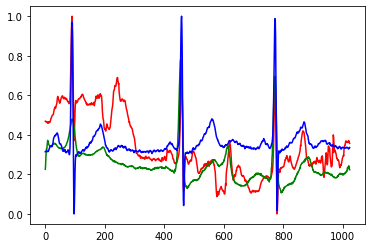

In [56]:
# show one of the result
k = 0 #return the k-th test result 
plt.figure()
plt.plot(range(0,1024),np.reshape(x_noise_data[validation_size+k,:],[1024]),'r-')
plt.plot(range(0,1024),np.reshape(decode_result[k,:],[1024]),'g-')
plt.plot(range(0,1024),np.reshape(x_correct_data[validation_size + k,:],[1024]),'b-')

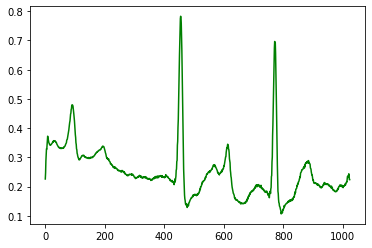

In [57]:
plt.plot(range(0,1024),np.reshape(decode_result[k,:],[1024]),'g-') # plot the denoising data seperatly

In [58]:
# save the denoising data
save_result = np.reshape(decode_result,[np.size(decode_result,0),np.size(decode_result,1)])#lower the data dimension
# save data
#output =  open('denoising.xlsx', 'wb')
outfile = 'denoising.npy'
np.save(outfile, save_result)  